In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from pathlib import Path

In [2]:
# Plot correlations:
def annotate(data, **kws):
    x = data['sc'].values
    y = data['vm'].values
    msk = np.isfinite(x) & np.isfinite(y)
    r, p = sp.stats.pearsonr(x[msk], y[msk])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)

In [3]:
current_folder = globals()['_dh'][0]
path_ann = current_folder / ".." / ".." / "data" / "prc" / "sc"
path_deconv = current_folder / ".." / ".." / "data" / "prc" / "vis" / "c2l_out"
output_path = current_folder / ".." / ".." / "out" / "deconvolution_eval"
output_path.mkdir(parents=True, exist_ok=True)

In [4]:
sample_meta = pd.read_excel(current_folder / ".." / ".." / "data" / "Metadata_all.xlsx", sheet_name="Visium")

In [5]:
# see deconv.py
def lookup(model_call, sample_entry):
    if model_call == "all":
        reg_model = "All"
    elif model_call == "condition":
        if sample_entry["Condition"] == "Control":
            reg_model = "Control"
        elif sample_entry["Condition"] == "MS":
            reg_model = "MS"
        else:
            raise ValueError("Unknown condition")
    elif model_call == "lesion_type":
        if sample_entry["lesion_type"] == "Ctrl":
            reg_model = "Control"
        elif sample_entry["lesion_type"] == "CI":
            reg_model = "CI"
        elif sample_entry["lesion_type"] == "CA":
            reg_model = "CA"
        elif sample_entry["lesion_type"] == "A":
            reg_model = "A"
        else:
            raise ValueError("Unknown lesion type")
    else:
        raise ValueError("Unknown model")
    return reg_model

In [6]:
def get_proportions(meta):
    return (meta
     .groupby(['sample_id', 'cell_types'])[['sample_id']]
     .count()
     .rename({'sample_id': 'n'}, axis=1)
     .reset_index()
     .assign(sc=lambda x: x['n'] / x.groupby('sample_id')['n'].transform('sum'))
     .drop('n', axis=1)
    )

In [7]:
annotated_meta = {method: get_proportions(sc.read_h5ad(path_ann / f"annotated_{method}_mod.h5ad").obs) for method in ["cellbender", "cellranger"]}

In [8]:
annotated_meta["cellranger"]

,sample_id,cell_types,sc
0,CO37,Astros,0.092611
1,CO37,Astros_c,0.002695
2,CO37,Astros_r,0.033896
3,CO37,B_cells,0.000142
4,CO37,Endothelia,0.007091
...,...,...,...
223,MS586,Neurons,0.008903
224,MS586,OPC,0.042128
225,MS586,Oligos,0.655592
226,MS586,Stroma,0.004777


In [9]:
annotated_meta["cellbender"]

,sample_id,cell_types,sc
0,CO37,Astros,0.105681
1,CO37,Astros_c,0.002267
2,CO37,B_cells,0.000000
3,CO37,Endothelia,0.005242
4,CO37,Microglia,0.056099
...,...,...,...
185,MS586,Neurons,0.006463
186,MS586,OPC,0.031157
187,MS586,Oligos,0.762181
188,MS586,Stroma,0.003480


In [10]:
def get_visium_prop(model_call, method, sample_meta):
    assert model_call in ["all", "condition", "lesion_type"]
    assert method in ["cellbender", "cellranger"]
    prop = []
    sample_ids = []
    for sample_id in os.listdir(path_deconv / method):
        sample_entry = sample_meta.loc[sample_meta.sample_id == sample_id, :].to_dict(orient="records")[0]
        suffix = lookup(model_call, sample_entry)
        if f"cell_props_{suffix}.csv" in os.listdir(path_deconv / method / sample_id):
            sample_ids.append(sample_id)
            tmp = AnnData(pd.read_csv(path_deconv / method / sample_id / f"cell_props_{suffix}.csv", index_col=0))
            tmp.obs['sample_id'] = sample_id
            prop.append(tmp)
        else:
            # raise Warning in the future, this should not happen!
            print(f"Missing {sample_id}")
    prop = prop[0].concatenate(prop[1:])

    # Compute average props for visium
    vm_df = pd.DataFrame(prop.X, index=prop.obs.index, columns=prop.var.index)
    vm_df['sample_id'] = prop.obs['sample_id']
    vm_df = vm_df.groupby('sample_id').mean(1)
    vm_df = vm_df.melt(value_vars=vm_df.columns, ignore_index=False).reset_index()
    vm_df = vm_df.rename({'variable': 'cell_types', 'value': 'vm'}, axis=1)
    return(vm_df)

In [11]:
visium_prop = {method: {model_call: get_visium_prop(model_call, method, sample_meta) for model_call in ["all", "condition", "lesion_type"]} for method in ["cellbender", "cellranger"]}

/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en

In [12]:
samples_oi = set(list(annotated_meta.values())[0].sample_id) & set(list(list(visium_prop.values())[0].values())[0].sample_id)
len(samples_oi)

17

In [13]:
visium_prop["cellranger"]["all"]

,sample_id,cell_types,vm
0,CO37,Astros,0.084948
1,CO40,Astros,0.052015
2,CO41,Astros,0.039678
3,CO74,Astros,0.150548
4,CO85,Astros,0.028234
...,...,...,...
259,MS497T,T_cells,0.010193
260,MS549H,T_cells,0.004080
261,MS549T,T_cells,0.010636
262,MS586,T_cells,0.007406


In [14]:
visium_prop["cellbender"]["all"]

,sample_id,cell_types,vm
0,CO37,Astros,0.094025
1,CO40,Astros,0.064057
2,CO41,Astros,0.055844
3,CO74,Astros,0.167521
4,CO85,Astros,0.034731
...,...,...,...
215,MS497T,T_cells,0.009374
216,MS549H,T_cells,0.007029
217,MS549T,T_cells,0.010883
218,MS586,T_cells,0.007247


In [15]:
def get_correlation(model_call, method, samples_oi, group, replace_zero=0.001):
    assert group in ["cell_types", "sample_id"]
    assert model_call in ["all", "condition", "lesion_type"]
    assert method in ["cellbender", "cellranger"]

    sc_prop = annotated_meta[method]
    vis_prop = visium_prop[method][model_call]

    # only keep rows where sample_id is in samples_oi
    sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
    vis_prop = vis_prop.loc[vis_prop.sample_id.isin(samples_oi), :]

    df = pd.merge(sc_prop, vis_prop, how='outer', on=['sample_id', 'cell_types'])
    df['sc'] = np.log10(df['sc'].replace({0: np.nan}))
    df['vm'] = np.log10(df['vm'].replace({0: np.nan}))
    df = df.fillna(np.log10(replace_zero))
    grouped_df = df.groupby(group)

    def pearson_corr(x):
        return x["sc"].corr(x["vm"], method="pearson")
    def spearman_corr(x):
        return x["sc"].corr(x["vm"], method="spearman")
    
    df_out = grouped_df.apply(pearson_corr).to_frame()
    df_out = df_out.rename({0: "Pearson_R"}, axis=1)
    df_out['Spearman_R'] = grouped_df.apply(spearman_corr)
    df_out["method"] = method
    df_out["model_call"] = model_call

    return df_out

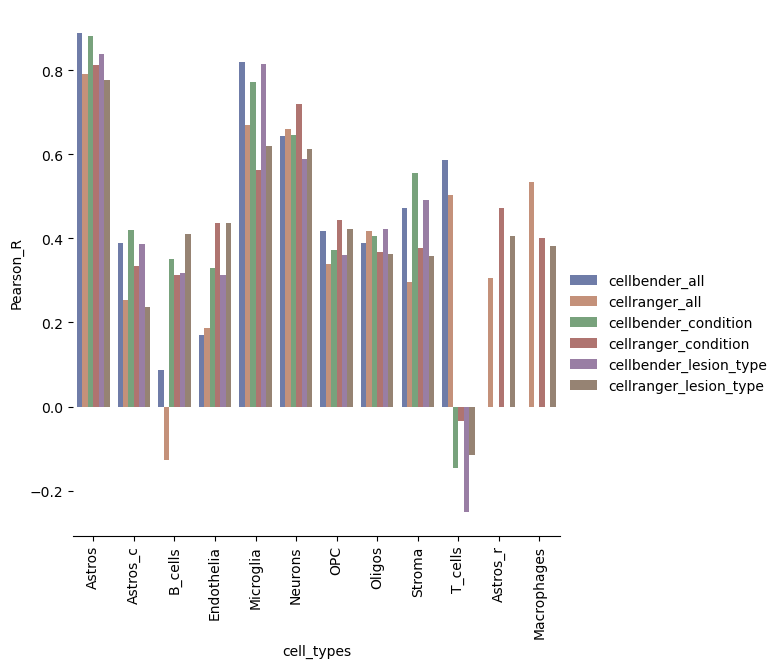

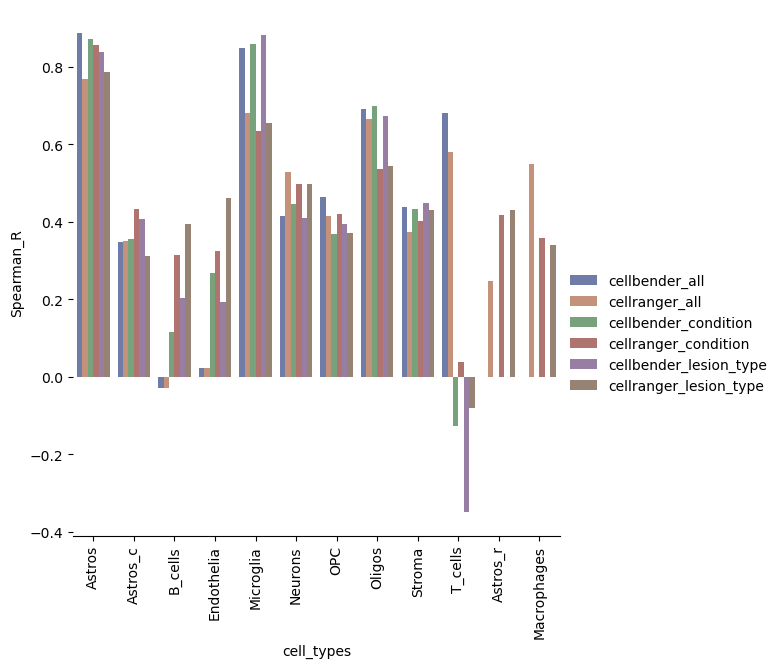

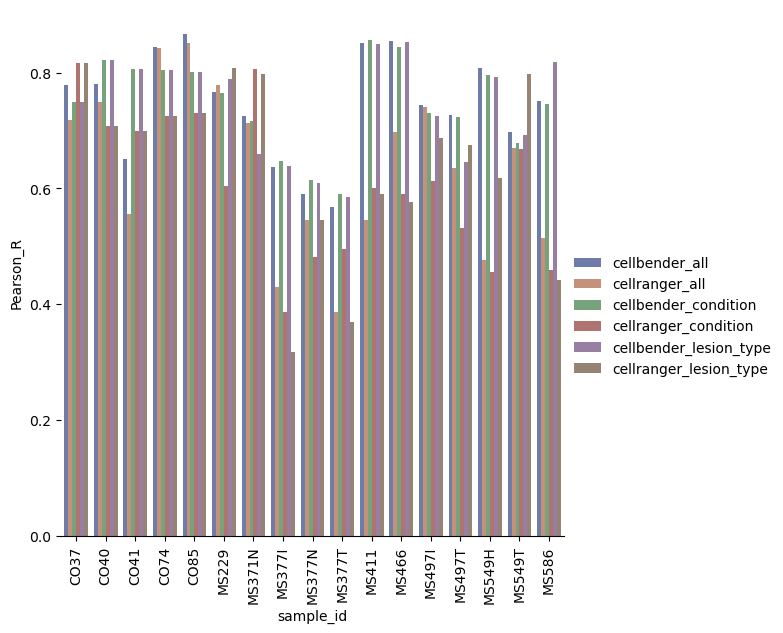

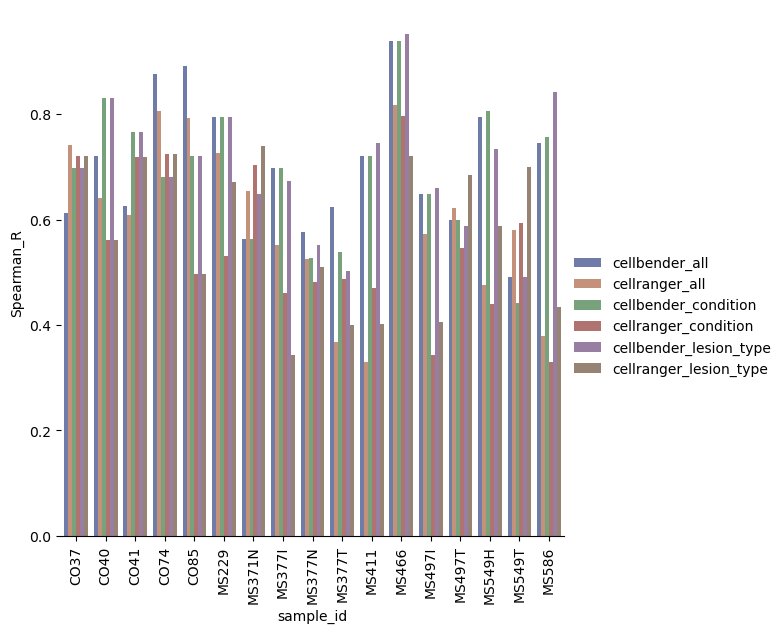

In [20]:
for group in ["cell_types", "sample_id"]:
    for metric in ["Pearson_R", "Spearman_R"]:
        df_list = []
        for model_call in ["all", "condition", "lesion_type"]:
            for method in ["cellbender", "cellranger"]:
                df_list.append(get_correlation(model_call, method, samples_oi, group=group))
        df = pd.concat(df_list)
        df["identifer"] = df["method"] + "_" + df["model_call"]
        df.reset_index(inplace=True)

        g = sns.catplot(
            data=df,
            x=group, y=metric, hue="identifer",
            kind="bar", palette="dark", alpha=.6, height=6
        )
        g.despine(left=True)
        g.legend.set_title("")
        g.set_xticklabels(rotation=90)
        g.savefig(output_path / f"barplot_{group}_{metric}.pdf")

In [18]:
def plot_correlation(model_call, method, samples_oi, replace_zero=0.001, save_path=None):
    sc_prop = annotated_meta[method]
    vis_prop = visium_prop[method][model_call]

    # only keep rows where sample_id is in samples_oi
    sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
    vis_prop = vis_prop.loc[vis_prop.sample_id.isin(samples_oi), :]

    df = pd.merge(sc_prop, vis_prop, how='outer', on=['sample_id', 'cell_types'])
    df['sc'] = np.log10(df['sc'].replace({0: np.nan}))
    df['vm'] = np.log10(df['vm'].replace({0: np.nan}))
    df = df.fillna(np.log10(replace_zero))

    # Plot corrs per cell type
    g = sns.lmplot(x='sc', y='vm', data=df, col='cell_types', col_wrap=4, height=3, facet_kws={"sharex": False, "sharey": False})
    g.map_dataframe(annotate)
    g.fig.set_facecolor('white')
    g.fig.suptitle(f'{method}_{model_call}_deconv_corr_celltype')
    g.fig.set_tight_layout(tight='pad')
    if save_path:
        g.fig.savefig(os.path.join(save_path, f'{method}_{model_call}_deconv_corr_celltype.pdf'), dpi=300)

    # Plot corrs per sample id
    g = sns.lmplot(x='sc', y='vm', data=df, col='sample_id', col_wrap=4, height=3, facet_kws={"sharex": False, "sharey": False})
    g.map_dataframe(annotate)
    g.fig.set_facecolor('white')
    g.fig.suptitle(f'{method}_{model_call}_deconv_corr_sample')
    g.fig.set_tight_layout(tight='pad')
    if save_path:
        g.fig.savefig(os.path.join(save_path, f'{method}_{model_call}_deconv_corr_sample.pdf'), dpi=300)

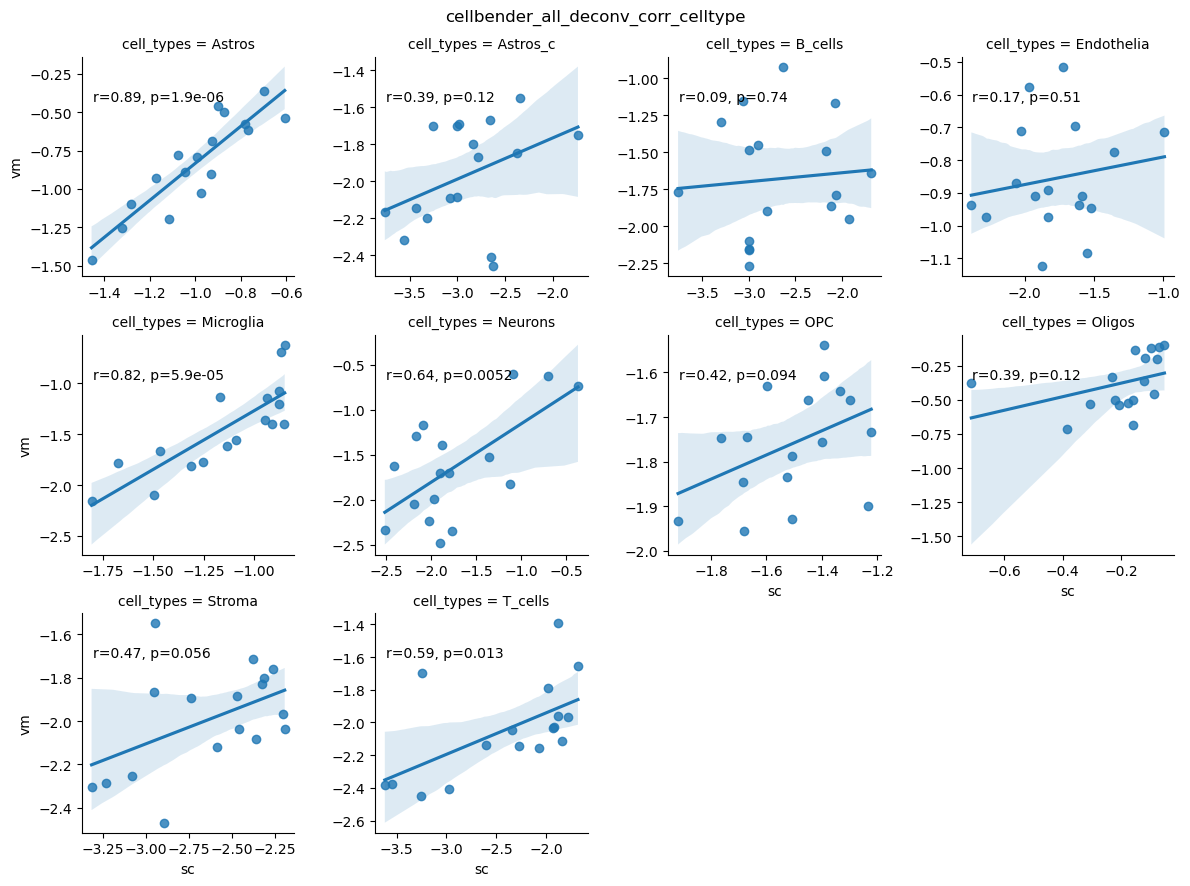

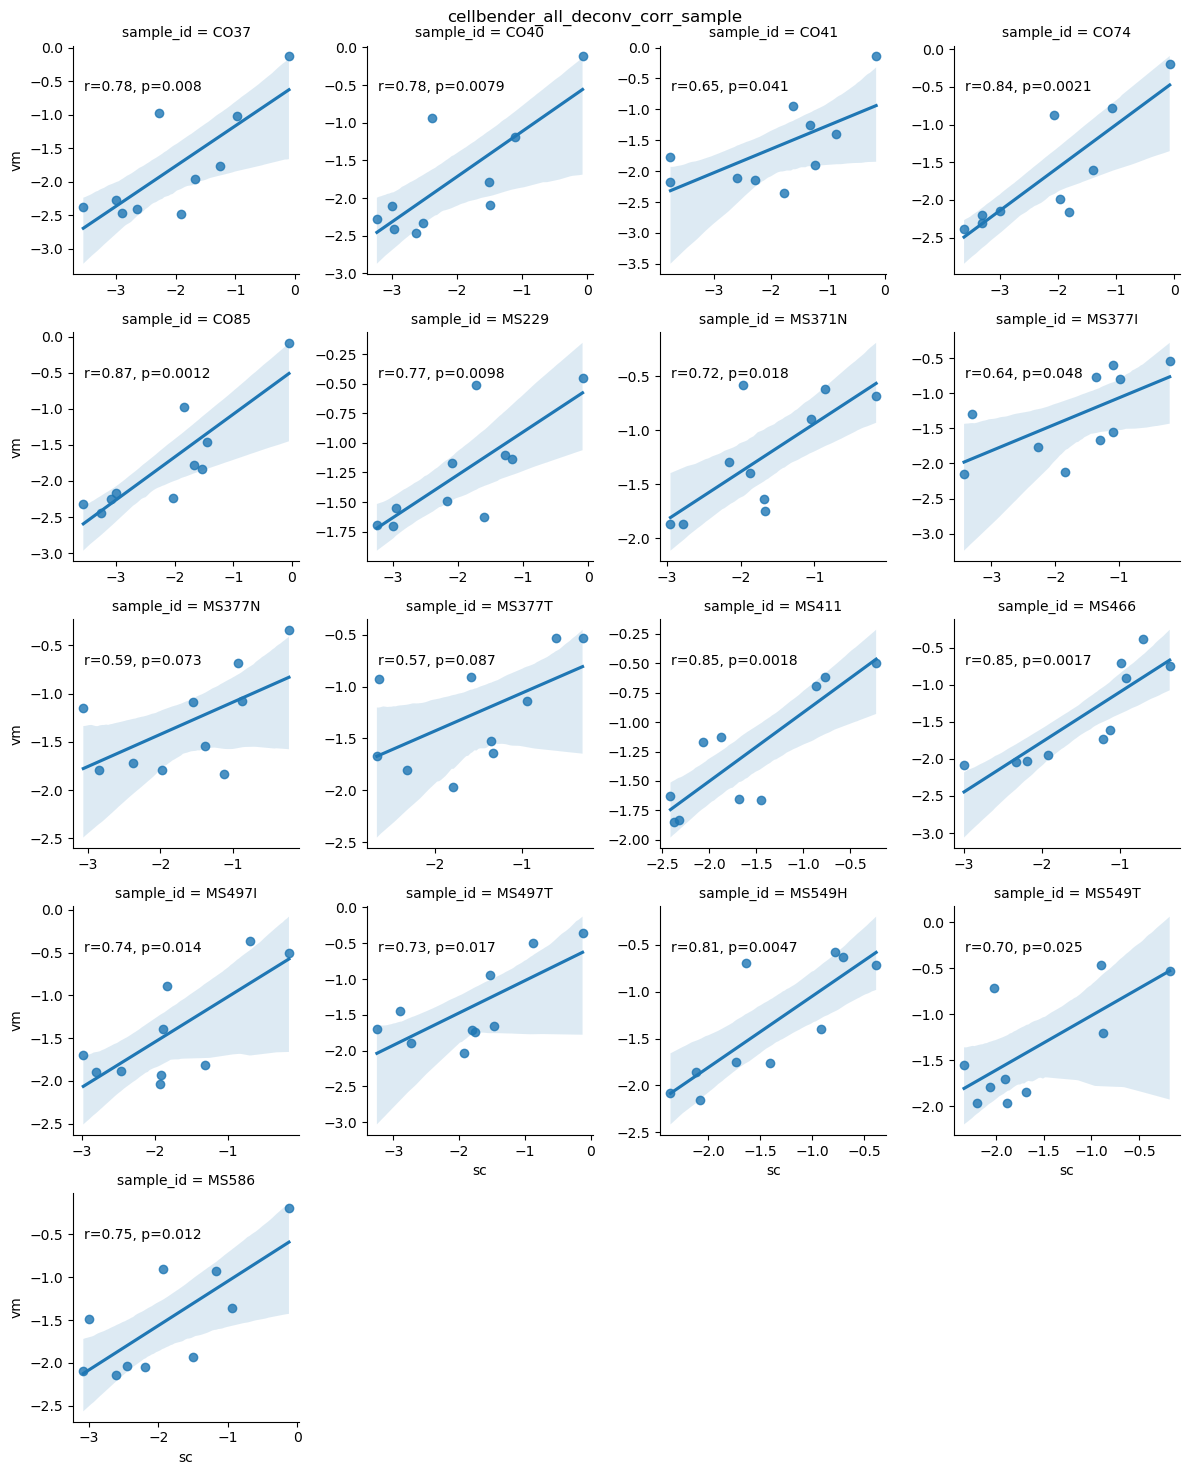

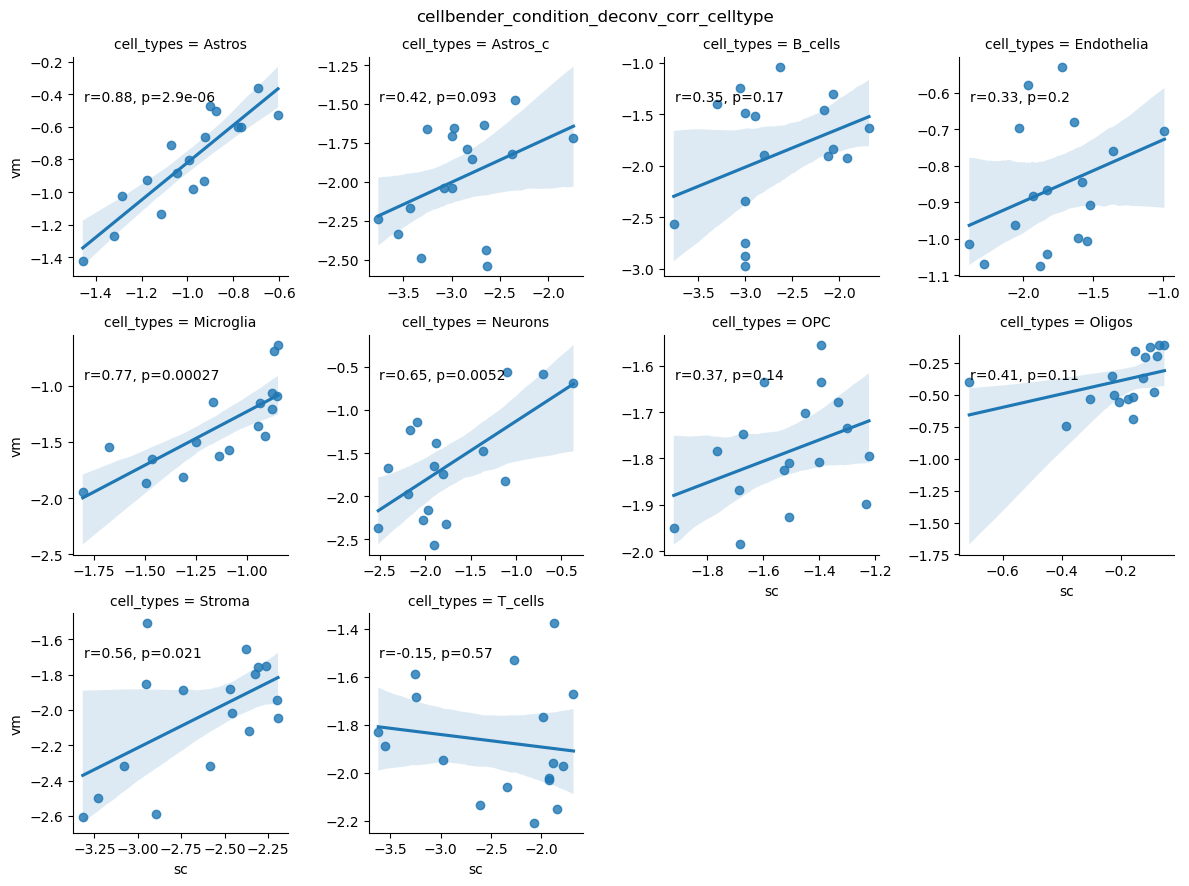

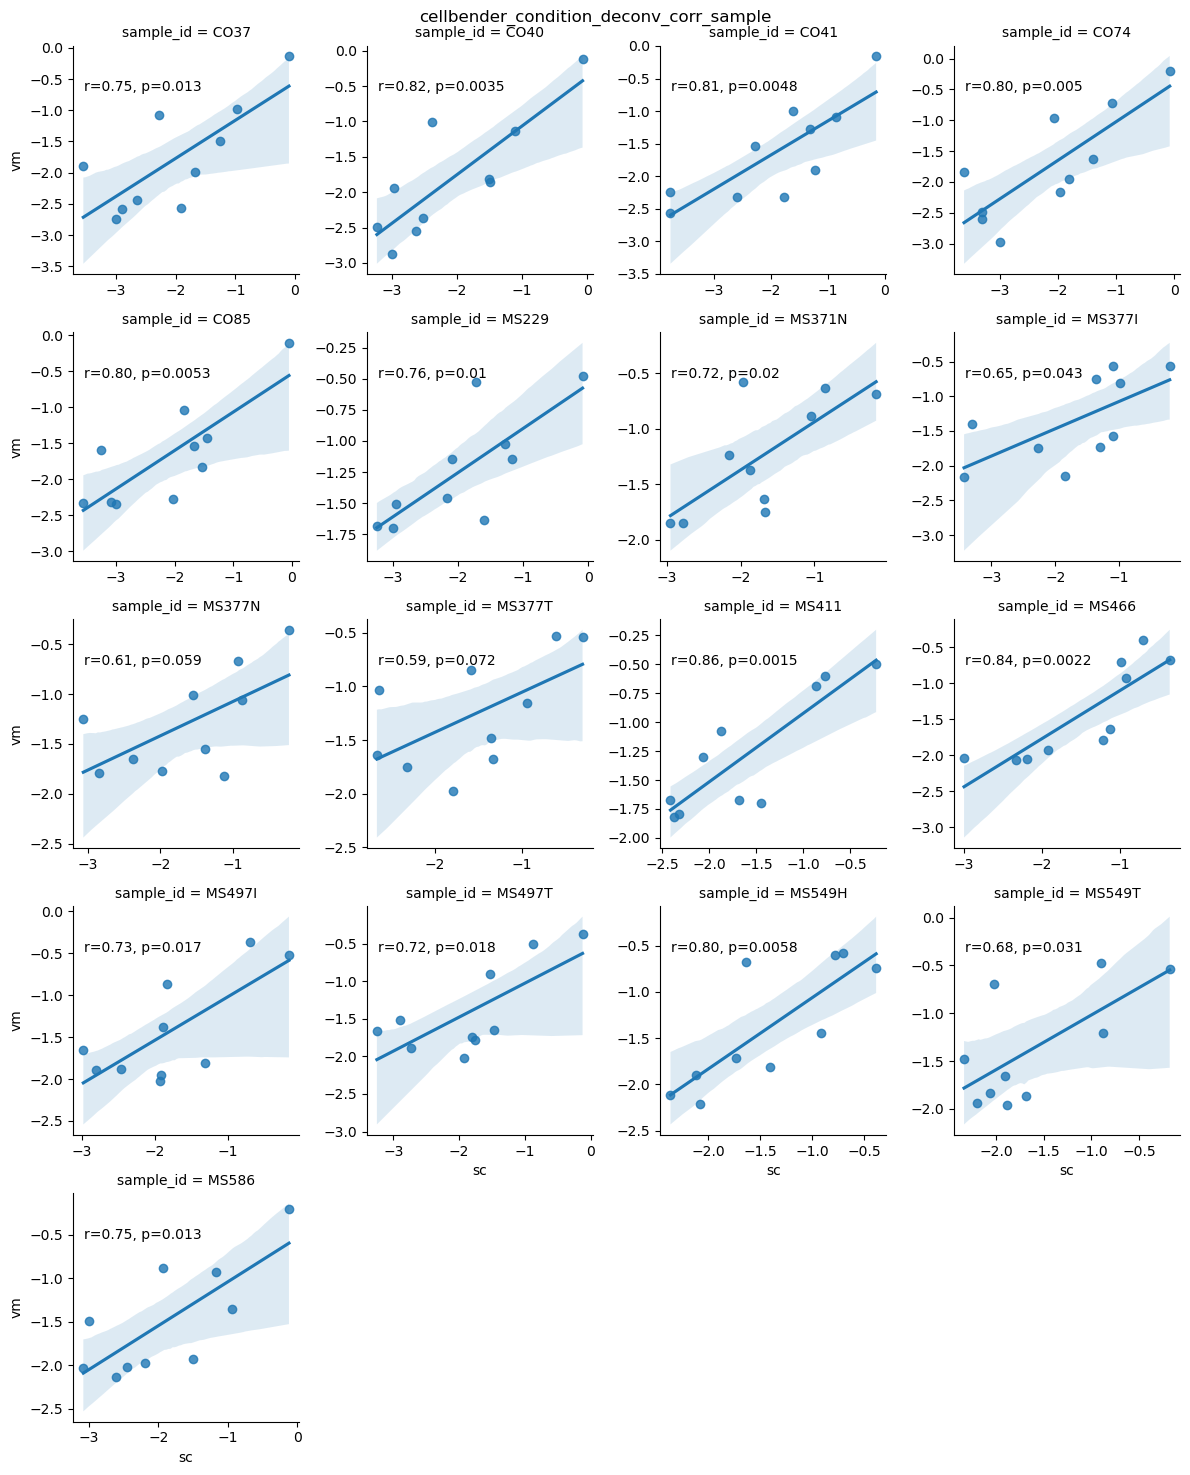

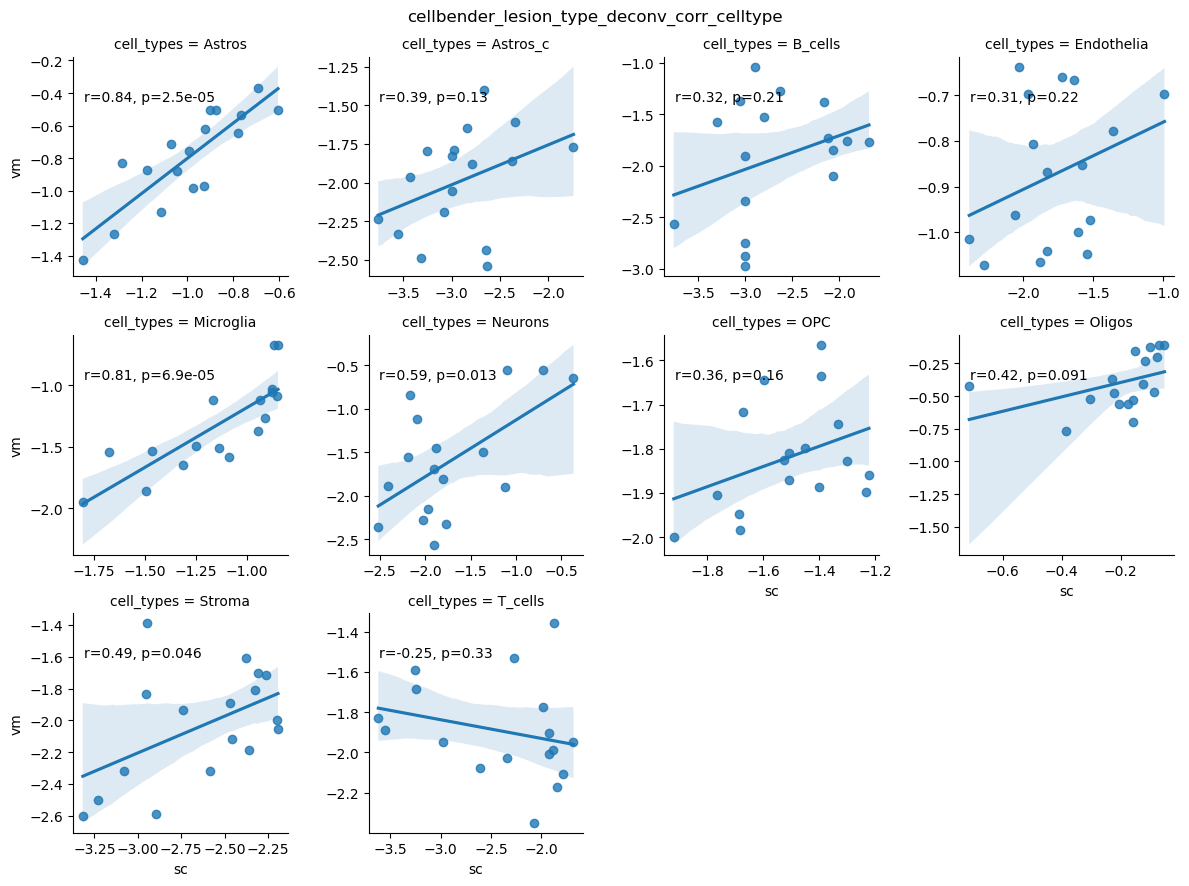

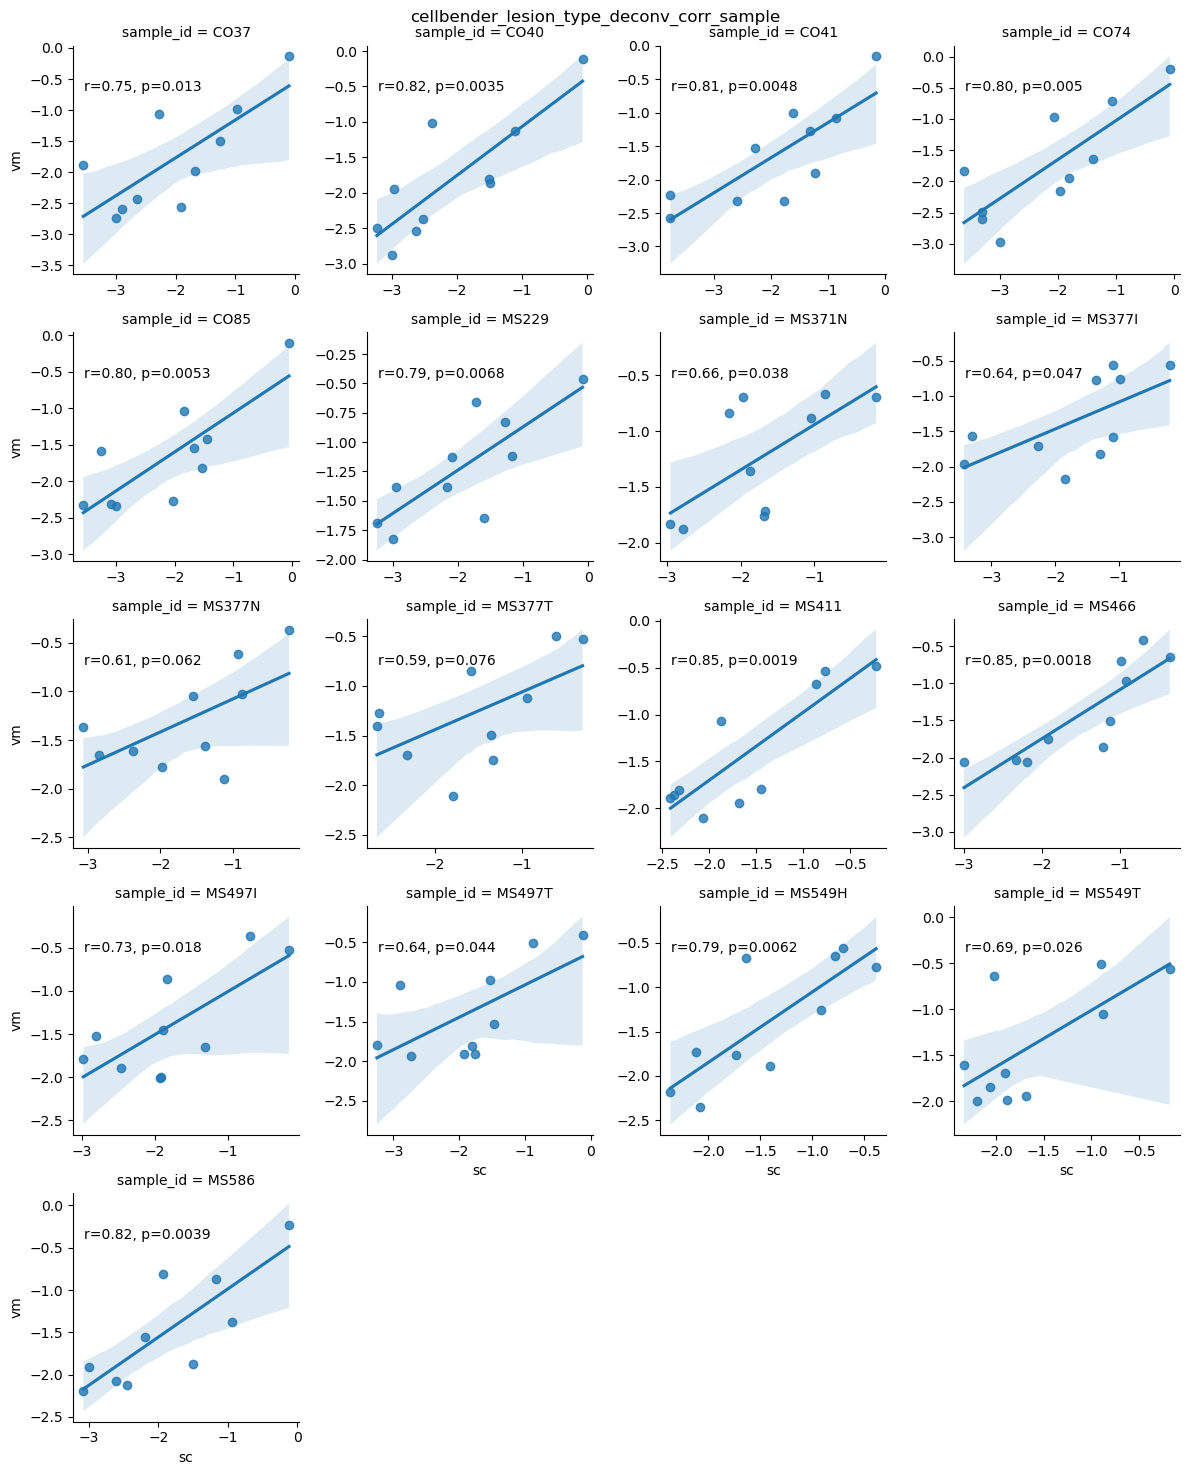

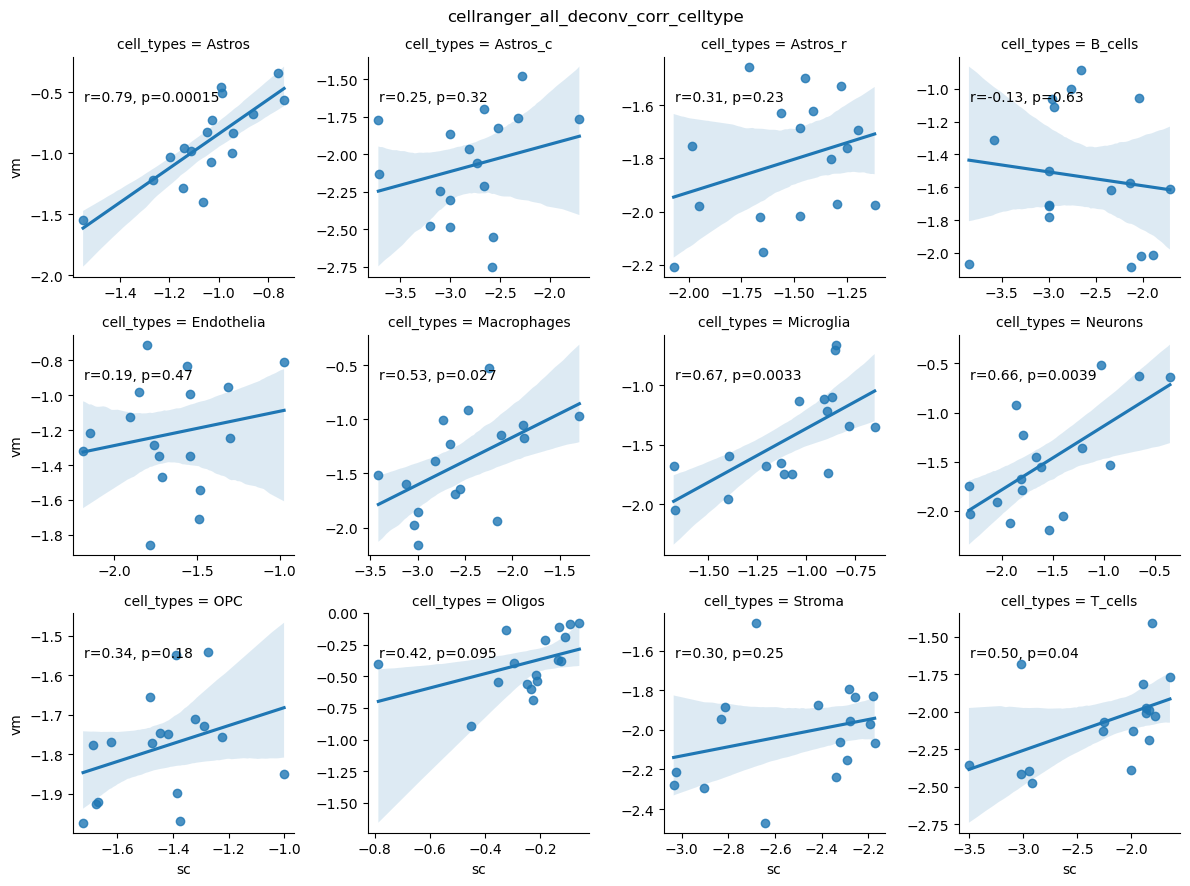

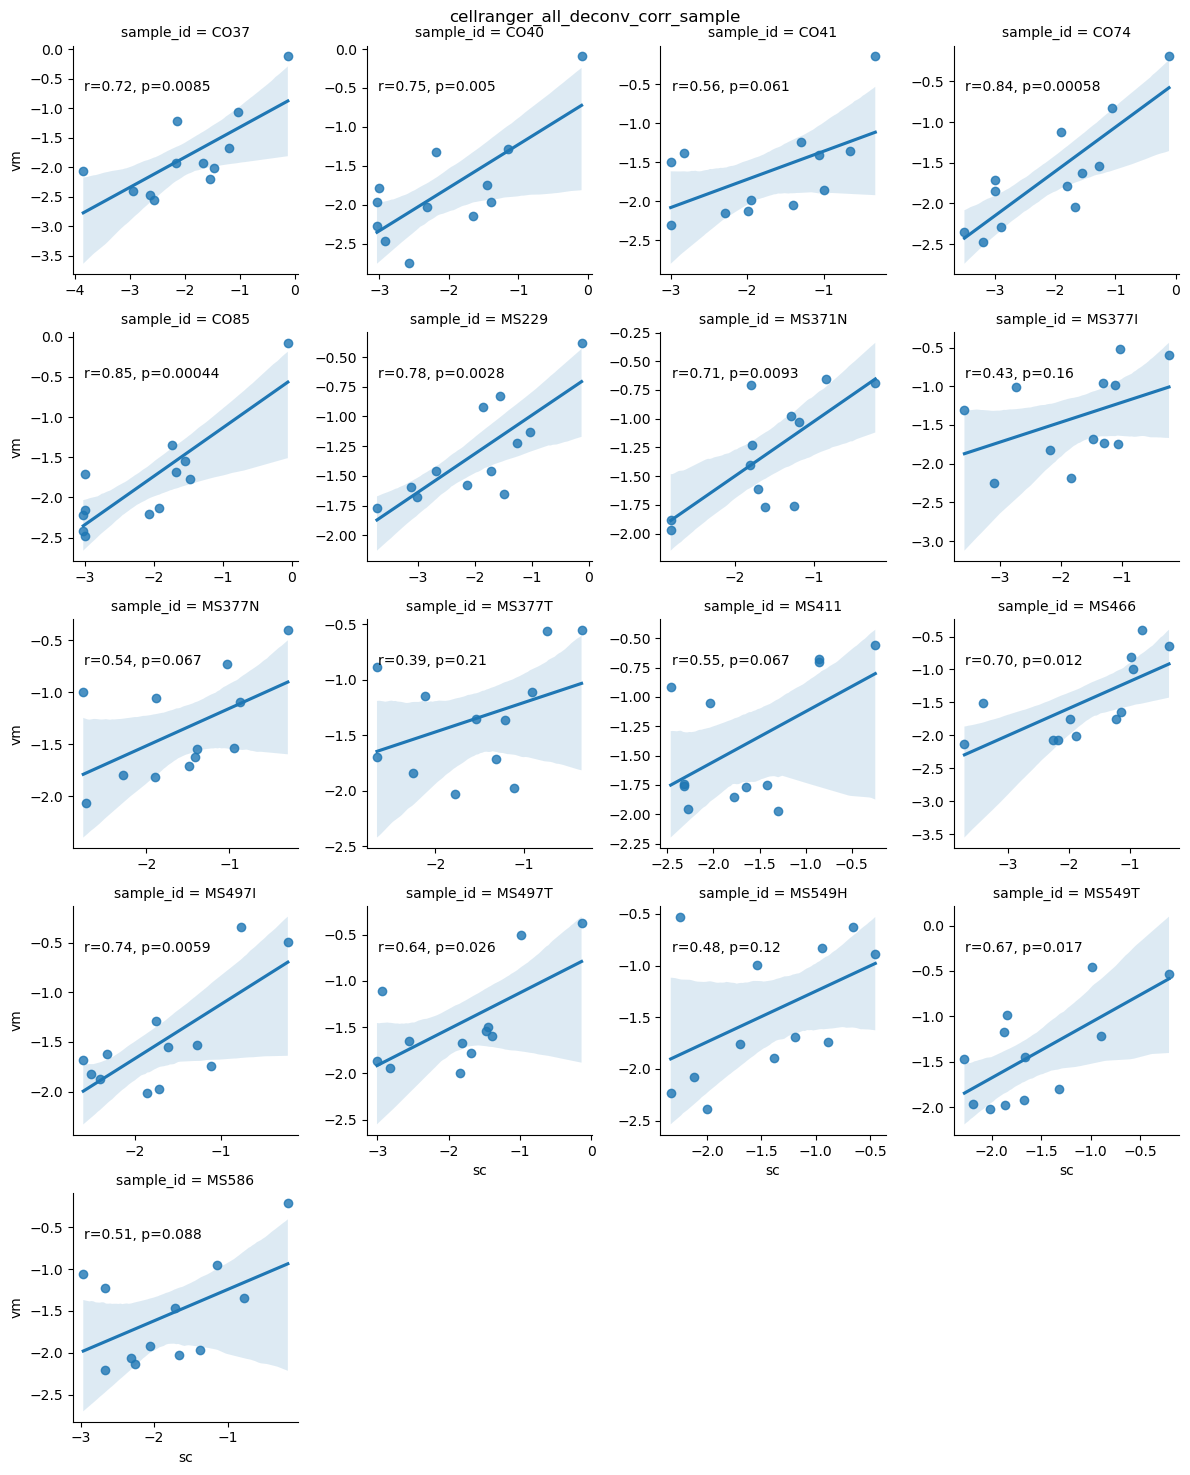

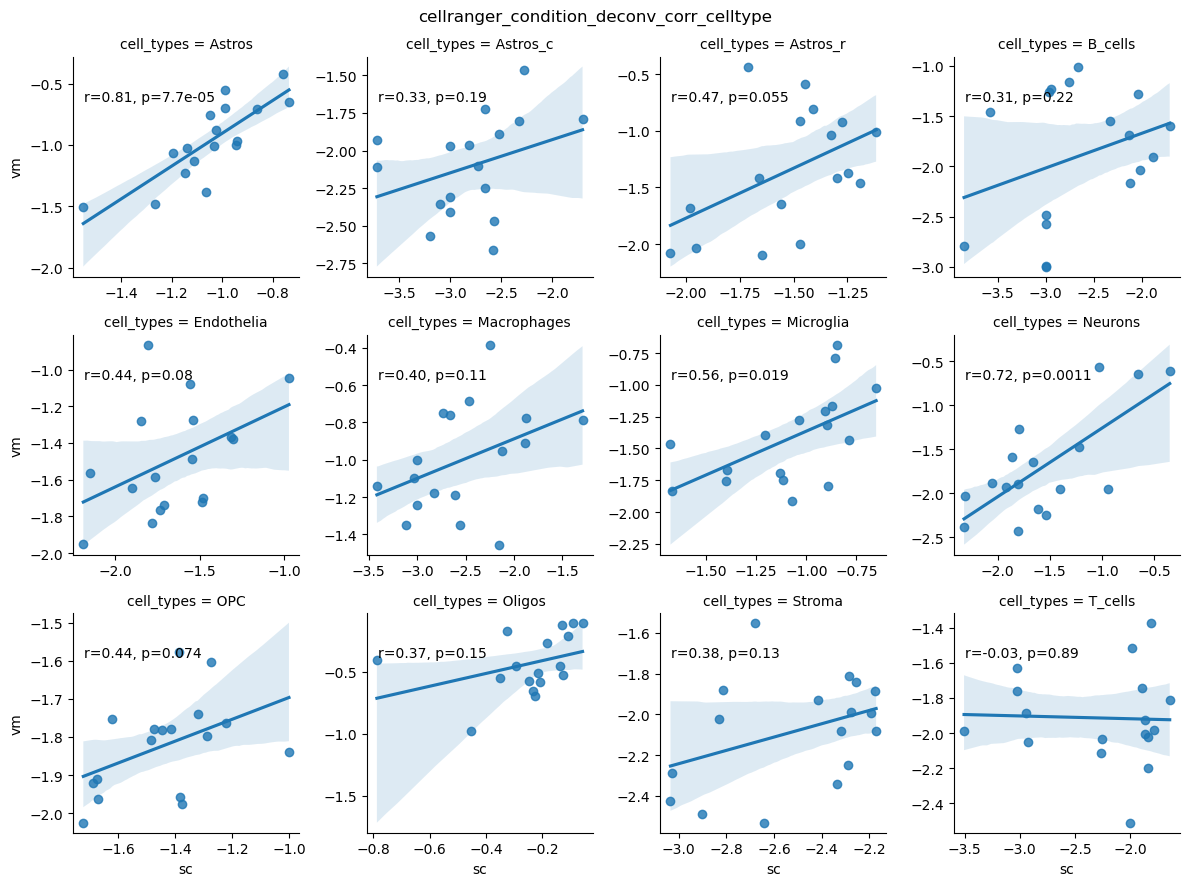

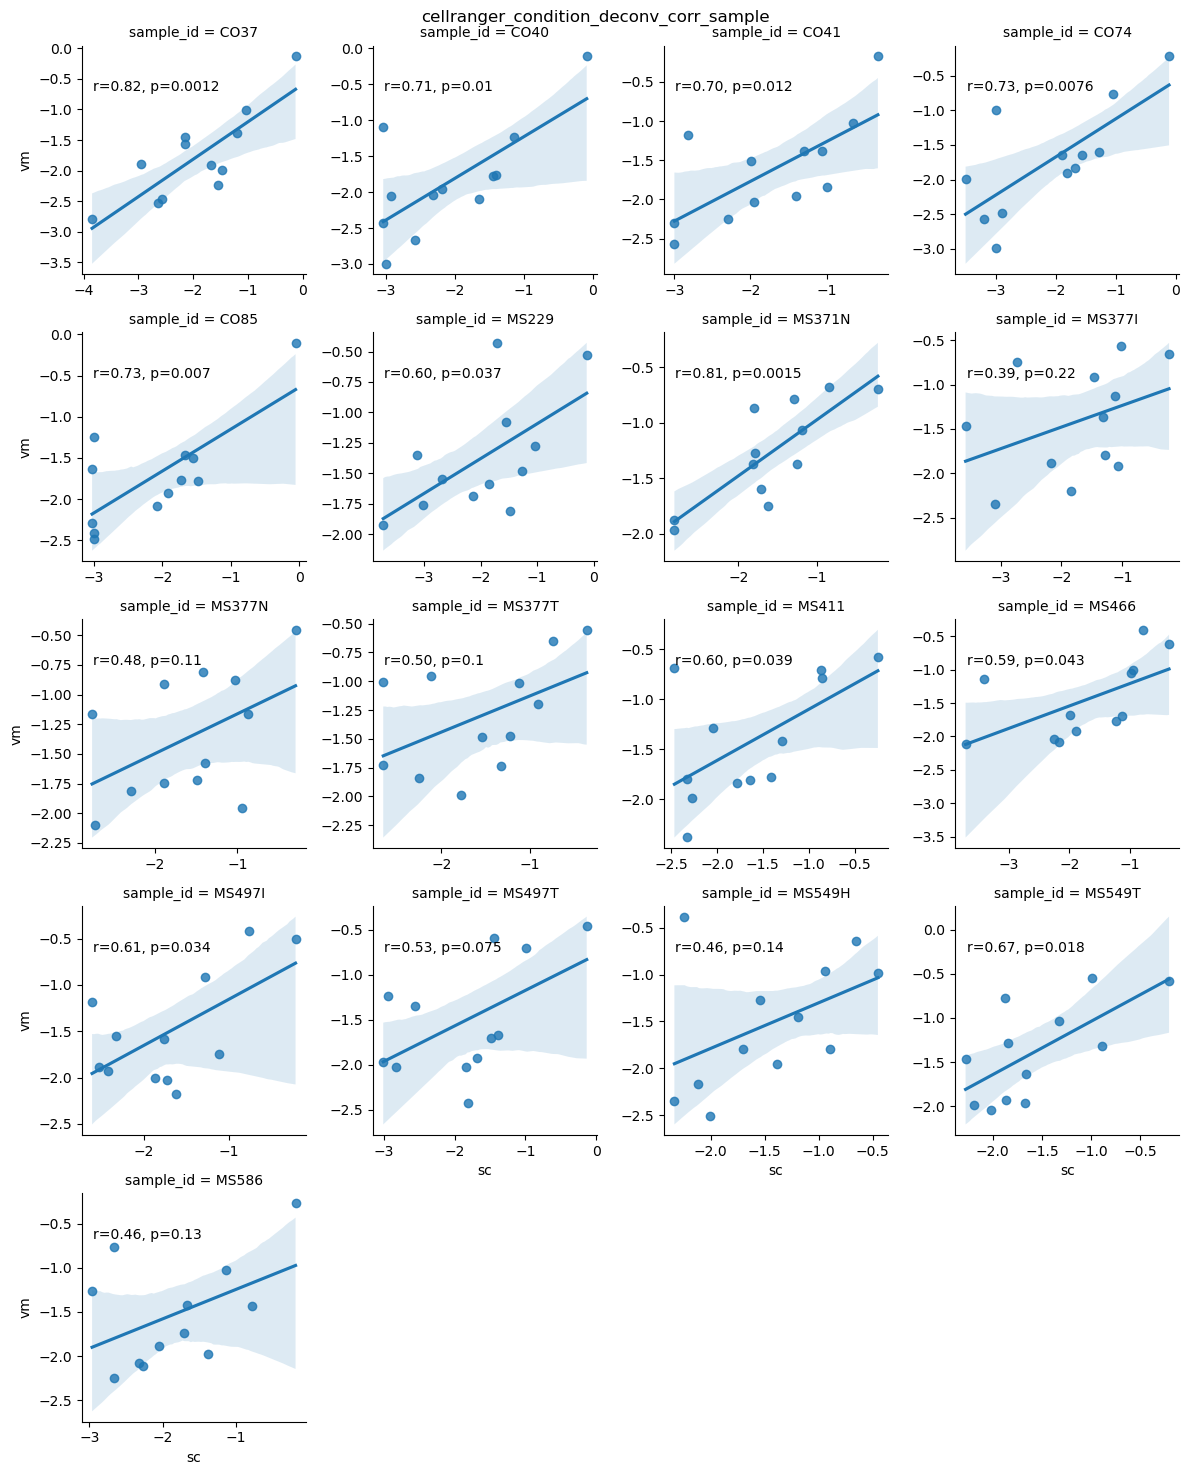

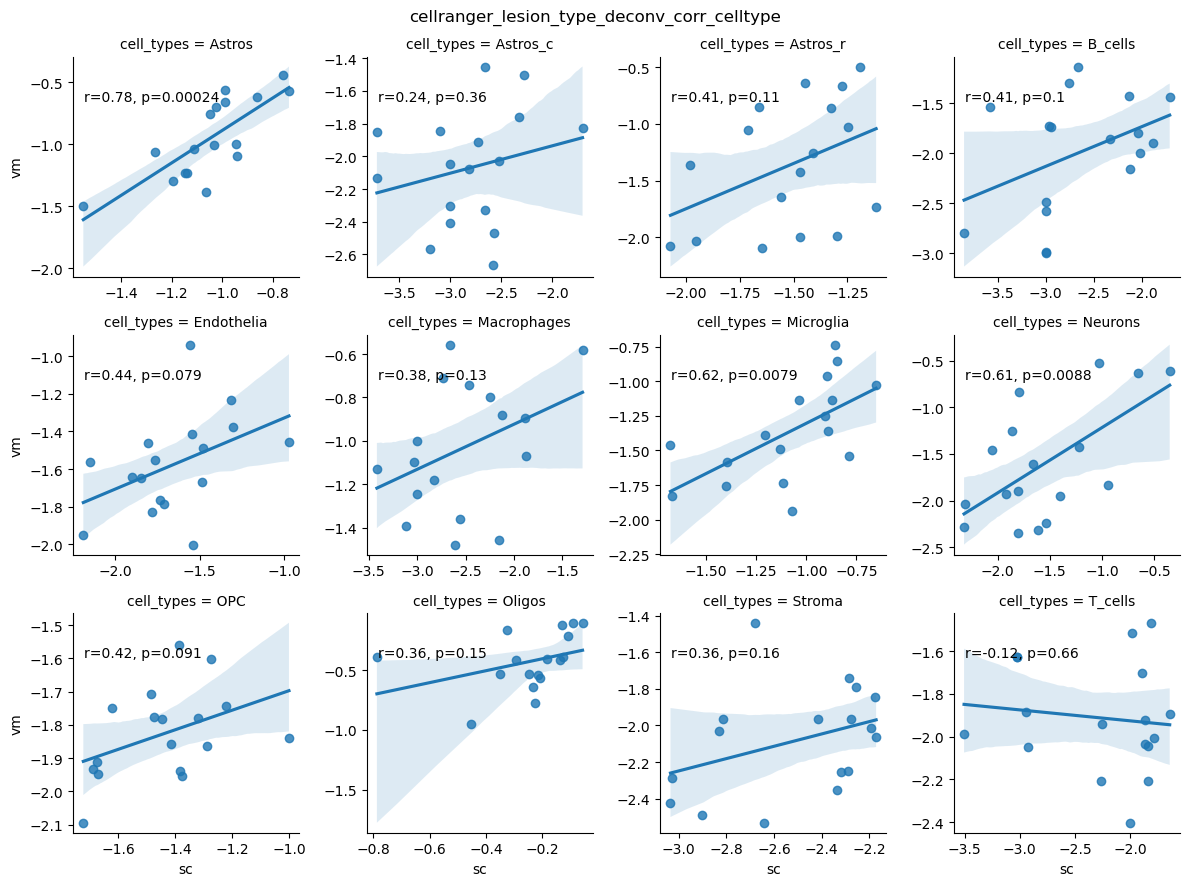

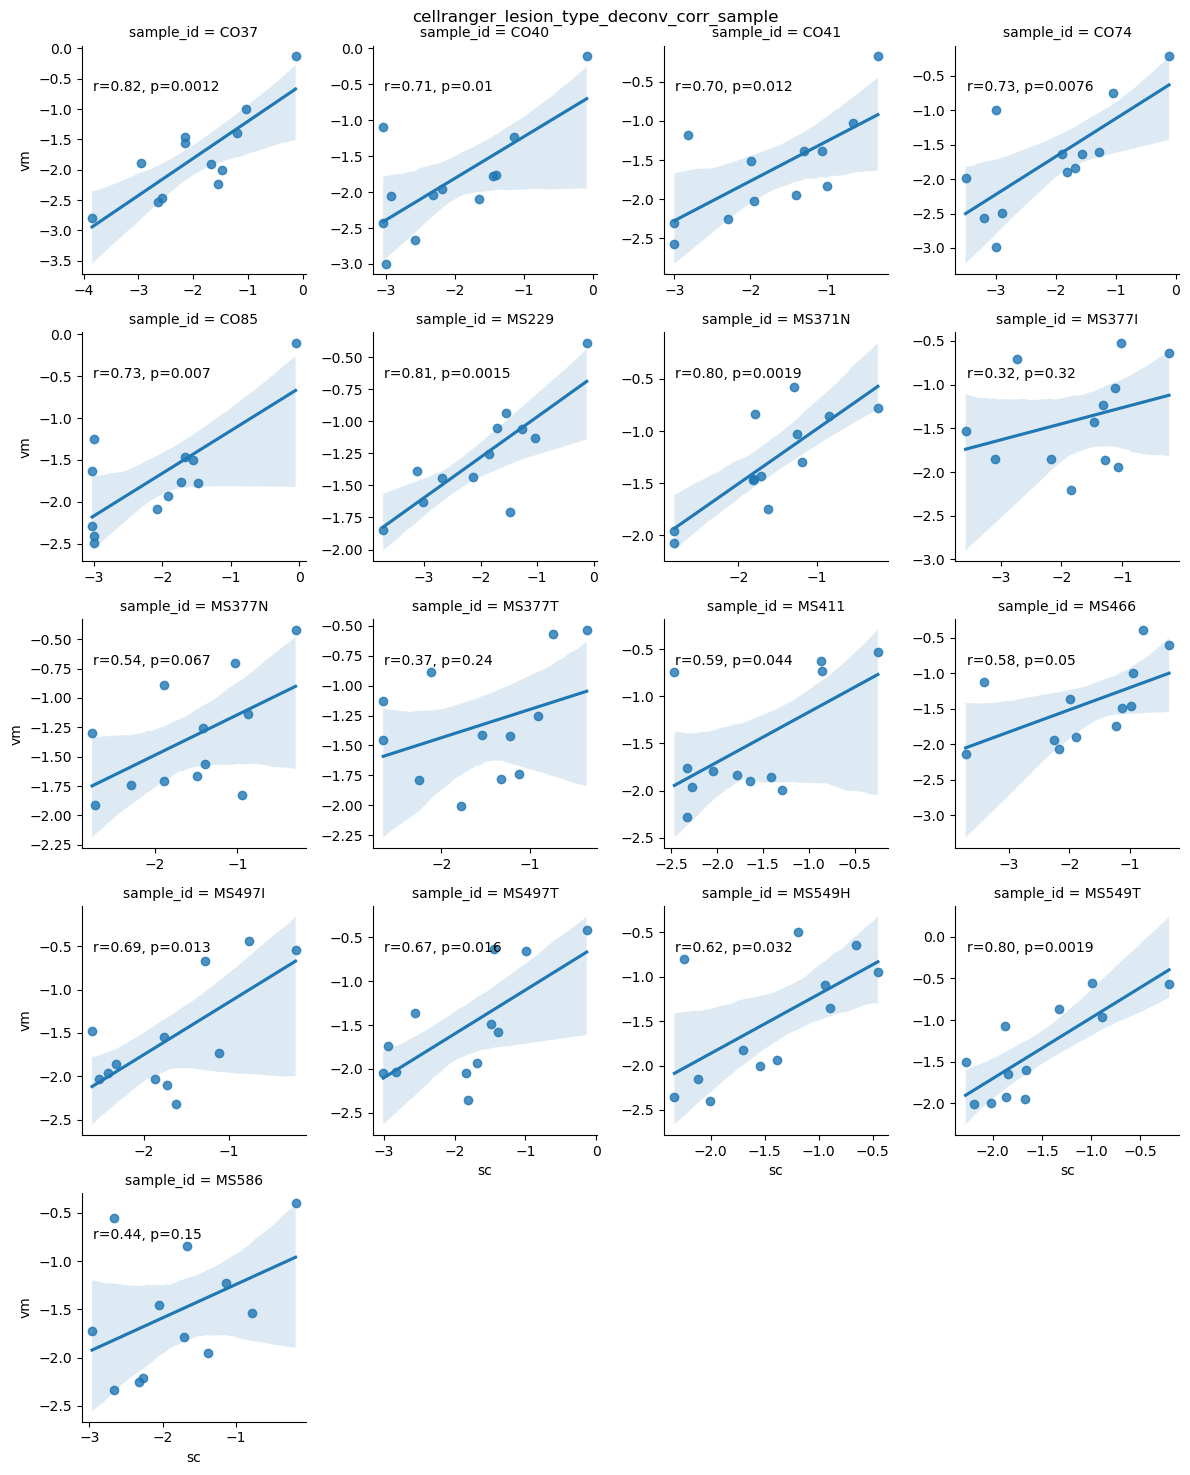

In [19]:
for method in ["cellbender", "cellranger"]:
    for model_call in ["all", "condition", "lesion_type"]:
        plot_correlation(model_call, method, samples_oi, save_path=output_path)